# The Security Characteristic Line

The Security Characteristic Line (SCL) is a graphical representation that illustrates the relationship between the excess returns of a security and the excess returns of the market portfolio. It is used in finance to assess the performance of a security relative to the market.

In this notebook I plot the SCL and report alphas, betas, R-squared and firm-specific volatility for different stocks. You can change the list of tickers to compute the same results for the stocks of your choice.

I'll start by importing the libraries for this analysis:

- `pandas` for data manipulation and time series operations
- `statsmodels` (formula API) for running OLS regressions with robust standard errors
- `seaborn` for creating the Security Characteristic Line visualizations
- `yfinance` for downloading stock prices and Treasury rates
- `warnings` to suppress non-critical FutureWarnings

You can modify the ticker list or date range in the subsequent cells to analyze different securities or time periods.

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import yfinance as yf

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

tickers = ['C', 'NVDA', 'SPY', 'BLK', 'TSLA', 'GE', 'BA']

start_date = '2015-08-31'
end_date = '2025-09-30'

I start by downloading data and computing monthly returns for different stocks. The analysis covers the period from August 2015 to September 2025, using monthly data to reduce noise while maintaining sufficient observations for statistical analysis.

First, I'll download closing prices for a diversified set of stocks including financial (C, BLK), technology (NVDA, TSLA), industrial (GE, BA), and market benchmark (SPY) securities. The data is resampled to month-end frequency and converted to monthly returns.

In [2]:
df = (
    yf.download(
        tickers=tickers,
        progress=False,
        start=start_date,
        end=end_date,
    )
    .loc[:, 'Close']
    .resample('ME')
    .last()
    .pct_change()
    .dropna()
)


Next, I download the risk-free rate using the 3-month Treasury bill rate (^IRX) and convert it to a monthly rate to match our return frequency.

In [3]:
rf = (
    yf.download(
        tickers=['^IRX'],
        start='2020-09-01',
        end='2025-09-30',
        progress=False,
    )
    .loc[:, 'Close']
    .resample("ME")
    .last()
    .dropna()
    .assign(RF=lambda x: x['^IRX'] / 12 / 100)
    .drop(columns=['^IRX'])
)

Finally, I calculate excess returns by subtracting the risk-free rate from each security's returns. 

In [4]:
excess_returns = df.sub(rf['RF'], axis=0).dropna()

In the rest of the analysis, I detach 'SPY' to a different dataset and stack all tickers in a single dataset.

In [5]:
spy = df.loc[:, ['SPY']]
stacked = excess_returns.drop(columns="SPY").stack().rename("RETRF").reset_index()
stacked.columns = ['Date', 'Ticker', 'RETRF']
stacked = stacked.sort_values(['Ticker', 'Date']).reset_index(drop=True)

The idea is then to merge `spy` with the stacked dataframe so that every stock excess returns can be matched with the corresponding market excess returns.

In [6]:
panel = stacked.merge(
    spy.rename(columns={'SPY': 'RMRF'}).reset_index(), on='Date', how='left'
)
panel.head()

,Date,Ticker,RETRF,RMRF
0,2020-09-30,BA,-0.038250,-0.037443
1,2020-10-31,BA,-0.126355,-0.024934
2,2020-11-30,BA,0.459249,0.108777
3,2020-12-31,BA,0.015844,0.037048
4,2021-01-31,BA,-0.092864,-0.010191


This way, `seaborn` can plot different regression lines for each stock in which the dependent variable is the excess returns of the stock and the independent variable is the excess returns of the market. The `seaborn` function `lmplot` allows to do that in a very elegant way.

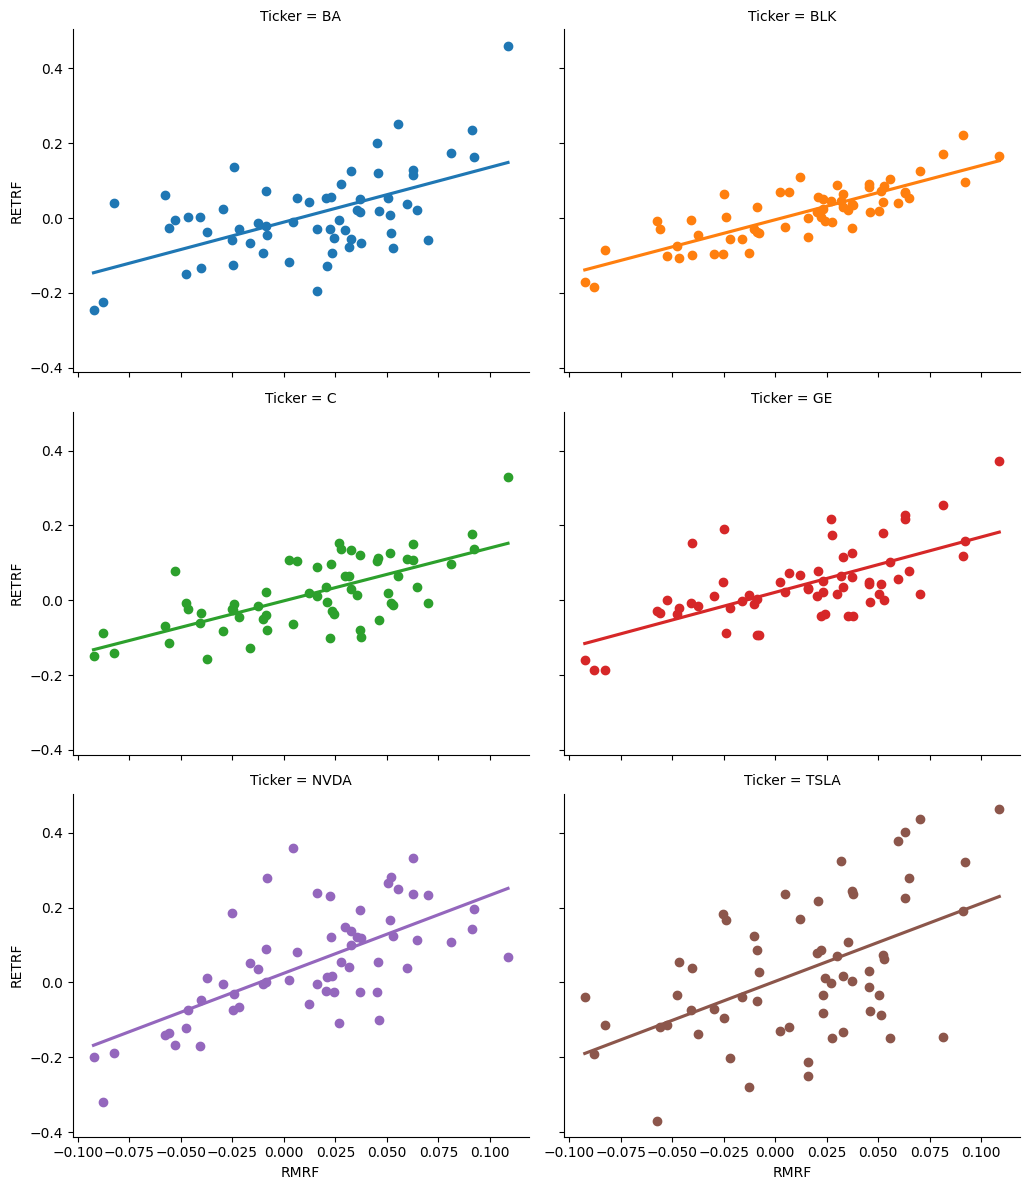

In [7]:
ax = sns.lmplot(
    data=panel,
    x='RMRF',
    y='RETRF',
    col='Ticker',
    hue='Ticker',
    col_wrap=2,
    ci=None,
    scatter_kws={'alpha': 1},
    height=4,
    aspect=1.3,
)

Finally, I generate a table with the regression results including alpha, beta, R-squared, and firm-specific volatility for each stock.

In [8]:
def regress(data):
    res = smf.ols(formula='RETRF ~ RMRF', data=data).fit(cov_type='HC1')
    return pd.Series(
        data=[
            res.params['Intercept'],
            res.pvalues['Intercept'],
            res.params['RMRF'],
            res.rsquared,
            res.resid.std() * (12**0.5) * 100,
        ],
        index=[
            ('Alpha', 'Estimate'),
            ('Alpha', 'P-value'),
            ('Beta', ''),
            ('R-Squared', ''),
            ('Residual Std', 'Annual (%)'),
        ],
    )


results = panel.groupby('Ticker').apply(regress, include_groups=False)
results.index.name = None
results.columns = pd.MultiIndex.from_tuples(results.columns)
results = results.round(
    {
        ('Alpha', 'Estimate'): 4,
        ('Alpha', 'P-value'): 3,
        ('Beta', ''): 3,
        ('R-Squared', ''): 3,
        ('Residual Std', 'Annual (%)'): 2,
    }
)
results

Alpha           Beta R-Squared Residual Std
     Estimate P-value                    Annual (%)
BA    -0.0109   0.379  1.465     0.323        33.69
BLK   -0.0047   0.445  1.450     0.697        15.16
C     -0.0017   0.847  1.414     0.461        24.28
GE     0.0211   0.035  1.480     0.434        26.79
NVDA   0.0245   0.078  2.085     0.437        37.53
TSLA   0.0028   0.885  2.085     0.269        54.48